In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_data():
    # 读取第一个CSV文件
    df = pd.read_csv('otherdata.csv')
    df = df.rename(columns={'byr_instn_cn_full_nm':'buyer','slr_instn_cn_full_nm':"seller", 'transactionVolume': 'volume', 'netPrice': "price", 'timeStamp': "date"})

    return df

def create_directed_graph(data):
    """
    根据数据创建一个多重有向图。
    Args:
        data (DataFrame): 数据帧，包含交易信息。

    Returns:
        nx.MultiDiGraph: 多重有向图对象。
    """
    G = nx.MultiDiGraph()
    # 添加节点和边
    for _, transaction in data.iterrows():
        buyer = transaction["buyer"]
        seller = transaction["seller"]
        volume = transaction["volume"]
        price = transaction["price"]
        time = transaction["date"]
        transaction_id = transaction["transactionId"]
        edge_attributes = {"buyer": buyer, "seller": seller, "volume": volume, "price": price, "time": time}
        G.add_edge(seller, buyer, key=transaction_id , **edge_attributes)
    return G

def visualize_graph(G):
    # 可视化有向图
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=2000, node_color='skyblue', font_size=10, arrows=True)
    plt.title('Directed Graph')
    plt.show()


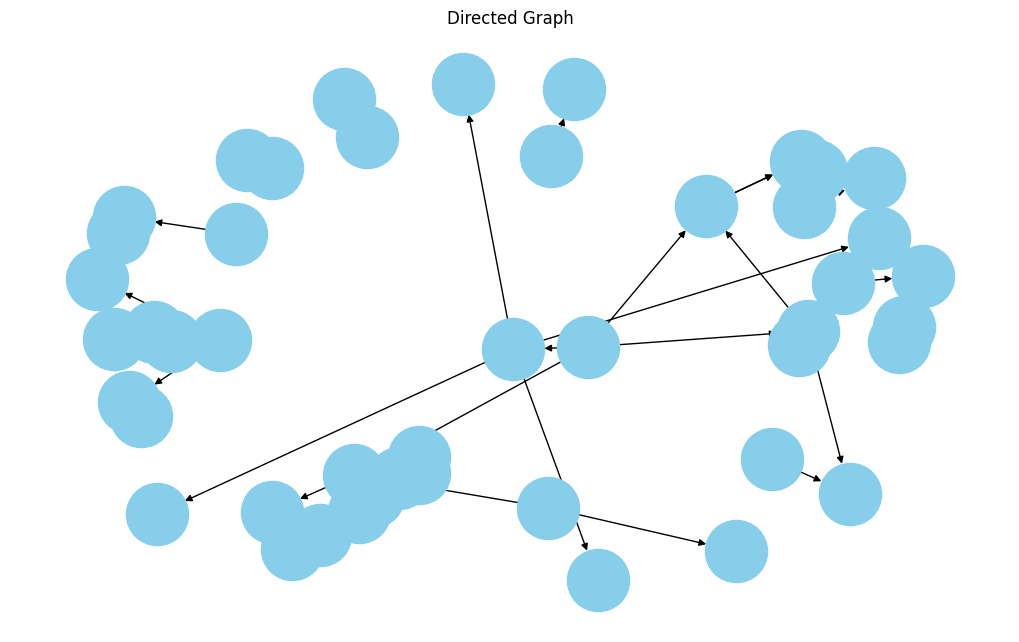

In [29]:
# 创建有向图
df = load_data()
G = create_directed_graph(df[0:40])
visualize_graph(G)

# 计算机构头寸

In [30]:
def calculate_position_and_trades(name, merged_df):
    transactions = merged_df[(merged_df['seller'] == name) | (merged_df['buyer'] == name)]
    # print(transactions)
    buy_transactions = transactions[transactions['buyer'] == name].sort_values(by='date').reset_index(drop=True)
    sell_transactions = transactions[transactions['seller'] == name].sort_values(by='date').reset_index(drop=True)

    # 记录交易次数的计数器
    trade_count = buy_transactions.shape[0] + sell_transactions.shape[0]
    # print(buy_transactions.shape[0], sell_transactions.shape[0])
    # print(sum(buy_transactions['volume']), sum(sell_transactions['volume']))

    def dp(buy_idx, sell_idx, remaining_buy, remaining_sell):
        nonlocal trade_count  # 使用nonlocal关键字引用外部的trade_count变量
        if buy_idx >= len(buy_transactions) or sell_idx >= len(sell_transactions):
            return remaining_buy - remaining_sell

        # 计算当前买入和卖出交易的抵消量
        offset = min(buy_transactions.loc[buy_idx]['volume'], sell_transactions.loc[sell_idx]['volume'])

        # 更新剩余买入和卖出交易量
        remaining_buy -= offset
        remaining_sell -= offset

        # 更新买入和卖出交易的索引
        next_buy_idx = buy_idx + (buy_transactions.loc[buy_idx]['volume'] == offset)
        next_sell_idx = sell_idx + (sell_transactions.loc[sell_idx]['volume'] == offset)

        # 统计交易次数
        trade_count += 1

        # 继续递归
        return dp(next_buy_idx, next_sell_idx, remaining_buy, remaining_sell)

    # 调用动态规划函数
    position = dp(0, 0, buy_transactions['volume'].sum(), sell_transactions['volume'].sum())
    transactions_info = {'buy_sum': sum(buy_transactions['volume']), 'sell_sum': sum(sell_transactions['volume']), 'buy_num': buy_transactions['volume'].shape[0], 'sell_num': sell_transactions['volume'].shape[0]}
    # 返回头寸和交易次数
    return position, transactions_info

def calculate_offset_profit(name, merged_df):
    transactions = merged_df[(merged_df['seller'] == name) | (merged_df['buyer'] == name)]
    buy_transactions = transactions[transactions['buyer'] == name].sort_values(by='date').reset_index(drop=True)
    sell_transactions = transactions[transactions['seller'] == name].sort_values(by='date').reset_index(drop=True)

    offset_profit = 0
    i = 0
    j = 0
    while i < len(buy_transactions) and j < len(sell_transactions):
        if buy_transactions['volume'][i] == sell_transactions['volume'][j]:
            offset_profit += (sell_transactions['price'][j] - buy_transactions['price'][i]) * buy_transactions['volume'][i]
            # print(sell_transactions['date'][j], sell_transactions['price'][j] - buy_transactions['price'][i])
            sell_transactions = sell_transactions.drop(j).reset_index(drop=True)
            i += 1
        elif buy_transactions['volume'][i] < sell_transactions['volume'][j]:
            offset_profit += (sell_transactions['price'][j] - buy_transactions['price'][i]) * buy_transactions['volume'][i]
            # print(sell_transactions['date'][j], sell_transactions['price'][j] - buy_transactions['price'][i])
            sell_transactions.at[j, 'volume'] -= buy_transactions['volume'][i]
            i += 1
        else:
            offset_profit += (sell_transactions['price'][j] - buy_transactions['price'][i]) * sell_transactions['volume'][j]
            # print(sell_transactions['date'][j], sell_transactions['price'][j] - buy_transactions['price'][i])
            buy_transactions.at[i, 'volume'] -= sell_transactions['volume'][j]
            j += 1

    return offset_profit

突出展示哪些？先把全部展示出来
头寸发生变化的，有盈利的。

数据类型：
机构、头寸、交易量、盈利、交易时间、交易类型、交易对手



In [31]:
buyer_seller_names = set(df['buyer']).union(set(df['seller']))
trader_transactions = list(buyer_seller_names)
# 计算每一个机构的价格列表的统计信息，作为节点的属性添加到图中
for name in trader_transactions:
    position, transactions_info = calculate_position_and_trades(name, df)
    profit = calculate_offset_profit(name, df)
    print(f"{name}:,profit: {profit}, Position: {position}, Transaction: {transactions_info}")

粤开证券股份许逸潇:,profit: 0.30000000000001137, Position: 20, Transaction: {'buy_sum': 25, 'sell_sum': 5, 'buy_num': 3, 'sell_num': 1}
中天证券股份贾梦洋:,profit: 0, Position: 5, Transaction: {'buy_sum': 5, 'sell_sum': 0, 'buy_num': 1, 'sell_num': 0}
江苏常熟农村叶方平:,profit: 0, Position: 10, Transaction: {'buy_sum': 10, 'sell_sum': 0, 'buy_num': 2, 'sell_num': 0}
广东顺德农村余扬宇:,profit: 0, Position: -2, Transaction: {'buy_sum': 0, 'sell_sum': 2, 'buy_num': 0, 'sell_num': 1}
中信证券股份李怿哲:,profit: 0, Position: 2, Transaction: {'buy_sum': 2, 'sell_sum': 0, 'buy_num': 1, 'sell_num': 0}
汇添富基金管李苏越:,profit: 0, Position: 8, Transaction: {'buy_sum': 8, 'sell_sum': 0, 'buy_num': 1, 'sell_num': 0}
万联证券股份华海龙:,profit: 0.030000000000001137, Position: 9, Transaction: {'buy_sum': 12, 'sell_sum': 3, 'buy_num': 3, 'sell_num': 1}
潍坊银行股份高伟丽:,profit: 0, Position: -2, Transaction: {'buy_sum': 0, 'sell_sum': 2, 'buy_num': 0, 'sell_num': 1}
潍坊银行股份罗凌:,profit: 0, Position: -2, Transaction: {'buy_sum': 0, 'sell_sum': 2, 'buy_num': 0, 'sell_nu

In [32]:
import json

In [33]:
# 假设 df 是你的 DataFrame，包含交易数据
buyer_seller_names = set(df['buyer']).union(set(df['seller']))
trader_transactions = list(buyer_seller_names)

nodes = []
links = []

for name in trader_transactions:
    position, transactions_info = calculate_position_and_trades(name, df)
    profit = calculate_offset_profit(name, df)
    # 添加节点信息
    nodes.append({
        "id": name,
        "position": int(position),
        "transactions_info": transactions_info,
        "profit": float(profit)
    })

# 构建边（链接）
for index, row in df.iterrows():
    links.append({
        "source": row['buyer'],
        "target": row['seller'],
        # "value": row['transaction_value']  # 假设有交易值字段
    })

# 创建图数据
graph_data = {
    "nodes": nodes,
    "links": links
}

# 将图数据导出为JSON格式
with open('otherdata.json', 'w') as f:
    json.dump(graph_data, f, indent=4)


In [34]:
import pandas as pd
import json
import networkx as nx

# 假设 df 是你的 DataFrame，包含交易数据
buyer_seller_names = set(df['buyer']).union(set(df['seller']))
trader_transactions = list(buyer_seller_names)

nodes = []
links = []

for name in trader_transactions:
    position, transactions_info = calculate_position_and_trades(name, df)
    profit = calculate_offset_profit(name, df)
    # 添加节点信息
    nodes.append({
        "id": name,
        "position": int(position),
        "transactions_info": transactions_info,
        "profit": int(profit)
    })

# 构建边（链接）
for index, row in df.iterrows():
    links.append({
        "source": row['buyer'],
        "target": row['seller'],
        # "value": row['transaction_value']  # 假设有交易值字段
    })

# 创建 NetworkX 图
G = nx.DiGraph()
for node in nodes:
    G.add_node(node["id"], **node)
for link in links:
    G.add_edge(link["source"], link["target"])

# Step 2: 计算每个节点的层次（层次遍历）
def calculate_node_levels(graph, root=None):
    if root is None:
        root = next(iter(graph.nodes))  # 选择第一个节点作为根节点
    levels = dict(nx.single_source_shortest_path_length(graph, root))
    return levels

# 假设从图中的第一个节点开始
node_levels = calculate_node_levels(G)

# Step 3: 根据层数忽略指定层数的叶子节点
def filter_graph_by_level(graph, levels, max_level):
    nodes_to_keep = {node for node, level in levels.items() if level < max_level}
    return graph.subgraph(nodes_to_keep).copy()

# 设置忽略层数，例如忽略层数为3
ignore_level = 8
filtered_G = filter_graph_by_level(G, node_levels, ignore_level)

# 提取过滤后的节点和边
filtered_nodes = [{"id": node, **data} for node, data in filtered_G.nodes(data=True)]
filtered_links = [{"source": u, "target": v} for u, v in filtered_G.edges]

# 创建过滤后的图数据
filtered_graph_data = {
    "nodes": filtered_nodes,
    "links": filtered_links
}

# 将过滤后的图数据导出为JSON格式
with open('otherdata.json', 'w') as f:
    json.dump(filtered_graph_data, f, indent=4)
